# Activation Patching by attention layers, mlps, and every token

In [1]:
from nnsight import LanguageModel
import torch
torch.set_grad_enabled(False)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
llm = LanguageModel("meta-llama/Llama-3.2-1B", device_map="auto", torch_dtype=torch.float32)

In [3]:
N_LAYERS = llm.model.config.num_hidden_layers
N_HEADS = llm.model.config.num_attention_heads
hidden_size = llm.model.layers[0].self_attn.q_proj.weight.shape[0]
HEAD_SIZE = hidden_size // N_HEADS

In [4]:
def run_activation_patching(prompts, answer_token_indices):  
    patching_results = {layer: {"attn": {}, "mlp": {}} for layer in range(N_LAYERS)}  # Pre-allocate layer keys
    z_l = {}

    with llm.trace() as tracer:
        # Clean run, grab clean activations for layer
        with tracer.invoke(prompts[0]) as invoker:
            clean_tokens = invoker.inputs[0][0]["input_ids"][0]
            for layer in range(N_LAYERS):
                z_l[layer] = {
                    "attn": llm.model.layers[layer].self_attn.output.save(),
                    "mlp": llm.model.layers[layer].mlp.output.save()
                }
            # Get logits from lm_head
            clean_logits = llm.lm_head.output
            clean_logit_difference = (clean_logits[0, -1, answer_token_indices[0][0]] - clean_logits[0, -1, answer_token_indices[0][1]]).save()

        # Corrupter run, grab the corrupted logits for later comparison    
        with tracer.invoke(prompts[1]) as invoker:
            corrupted_logits = llm.lm_head.output
            corrupted_logit_difference = (corrupted_logits[0, -1, answer_token_indices[0][0]] - corrupted_logits[0, -1, answer_token_indices[0][1]]).save()
    
    # Patching
    # Start with the activation patching. We take the average of the clean and reversed activations and use the first prompt set for patching: iterate through all the layers
    for layer in range(N_LAYERS):
        for token_idx in range(len(clean_tokens)):  
            with llm.trace(prompts[1]):
                # Activation patching MLP
                # mlp_output = llm.model.layers[layer].mlp.output.save() # for testing
                llm.model.layers[layer].mlp.output[:, token_idx, :] = z_l[layer]["mlp"][:, token_idx, :]
                patched_logits = llm.lm_head.output
                patched_logit_difference = (patched_logits[0, -1, answer_token_indices[0][0]] - patched_logits[0, -1, answer_token_indices[0][1]]).save()
                patched_result = (patched_logit_difference - corrupted_logit_difference) / (clean_logit_difference - corrupted_logit_difference)
                patching_results[layer]["mlp"][f"token_{token_idx}"] = patched_result.item().save() 

            with llm.trace(prompts[1]):
                # Activation patching attention
                # self_attn_output = llm.model.layers[layer].self_attn.output.save() # for testing
                llm.model.layers[layer].self_attn.output[0][:, token_idx, :] = z_l[layer]["attn"][0][:, token_idx, :]
                patched_logits = llm.lm_head.output
                patched_logit_difference = (patched_logits[0, -1, answer_token_indices[0][0]] - patched_logits[0, -1, answer_token_indices[0][1]]).save()
                patched_result = (patched_logit_difference - corrupted_logit_difference) / (clean_logit_difference - corrupted_logit_difference)
                patching_results[layer]["attn"][f"token_{token_idx}"] = patched_result.item().save() 

    patching_results = {
        "clean_run_logit_difference": clean_logit_difference,
        "corrupted_run_logit_difference": corrupted_logit_difference,
        "patching_results": patching_results    
    }

    return patching_results, clean_tokens 

In [33]:
def plot_patching_effects_single_heatmap_mlp_attn_combined(patching_results, patching_results_reversed, clean_tokens, corrupted_tokens, prompt_row):
    # Plotting: Two heatmaps side by side with Attention and MLP interleaved on Y-axis
    N_LAYERS = len(patching_results["patching_results"])
    seq_len = len(clean_tokens)
    seq_len_corrupted = len(corrupted_tokens)

    # Extract data for attention and MLP for both patching_results and patching_results_reversed
    combined_effects = np.zeros((N_LAYERS * 2, seq_len))  # For patching_results
    combined_effects_reversed = np.zeros((N_LAYERS * 2, seq_len))  # For patching_results_reversed

    # Process patching_results
    for layer in range(N_LAYERS):
        for token_idx in range(seq_len):
            attn_effect = float(patching_results["patching_results"][layer]["attn"][f"token_{token_idx}"].value)
            mlp_effect = float(patching_results["patching_results"][layer]["mlp"][f"token_{token_idx}"].value)
            combined_effects[layer * 2, token_idx] = attn_effect      # Attention row
            combined_effects[layer * 2 + 1, token_idx] = mlp_effect  # MLP row

    # Process patching_results_reversed
    for layer in range(N_LAYERS):
        for token_idx in range(seq_len):
            attn_effect = float(patching_results_reversed["patching_results"][layer]["attn"][f"token_{token_idx}"].value)
            mlp_effect = float(patching_results_reversed["patching_results"][layer]["mlp"][f"token_{token_idx}"].value)
            combined_effects_reversed[layer * 2, token_idx] = attn_effect      # Attention row
            combined_effects_reversed[layer * 2 + 1, token_idx] = mlp_effect  # MLP row

    clean_diff = float(patching_results["clean_run_logit_difference"].item())
    corrupted_diff = float(patching_results["corrupted_run_logit_difference"].item())
    clean_diff_reversed = float(patching_results_reversed["clean_run_logit_difference"].item())
    corrupted_diff_reversed = float(patching_results_reversed["corrupted_run_logit_difference"].item())

    # Create the figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10), sharey=True)

    # Heatmap 1: patching_results
    im1 = ax1.imshow(combined_effects, cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)
    ax1.set_title('Patching Effects (Original Order)', fontsize=14)
    ax1.set_xlabel('Token', fontsize=12)
    ax1.set_ylabel('Layer (Attention | MLP)', fontsize=12)

    # X-axis: Token labels for the first subplot
    token_labels = [llm.tokenizer.decode([tok]) for tok in clean_tokens]
    ax1.set_xticks(np.arange(seq_len))
    ax1.set_xticklabels(token_labels, fontsize=10, rotation=45, ha='right')

    # Y-axis: Interleave Attention and MLP labels for each layer (shared)
    y_labels = []
    for layer in range(N_LAYERS):
        y_labels.extend([f'Attn {layer}', f'MLP {layer}'])
    ax1.set_yticks(np.arange(N_LAYERS * 2))
    ax1.set_yticklabels(y_labels, fontsize=10)

    # Add grid lines to the first subplot, aligned with cell boundaries using minor ticks
    ax1.set_xticks(np.arange(seq_len + 1) - 0.5, minor=True)  # Minor ticks at boundaries for grid
    ax1.set_yticks(np.arange(N_LAYERS * 2 + 1) - 0.5, minor=True)  # Minor ticks at boundaries for grid
    ax1.grid(True, which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    # Heatmap 2: patching_results_reversed
    token_labels_corrupted = [llm.tokenizer.decode([tok]) for tok in corrupted_tokens]
    im2 = ax2.imshow(combined_effects_reversed, cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)
    ax2.set_title('Patching Effects (Reversed Order)', fontsize=14)
    ax2.set_xlabel('Token', fontsize=12)

    # X-axis: Token labels for the second subplot
    ax2.set_xticks(np.arange(seq_len_corrupted))
    ax2.set_xticklabels(token_labels_corrupted, fontsize=10, rotation=45, ha='right')

    # Add grid lines to the second subplot, aligned with cell boundaries using minor ticks
    ax2.set_xticks(np.arange(seq_len_corrupted + 1) - 0.5, minor=True)  # Minor ticks at boundaries for grid
    ax2.set_yticks(np.arange(N_LAYERS * 2 + 1) - 0.5, minor=True)  # Minor ticks at boundaries for grid (shared with ax1)
    ax2.grid(True, which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    # Add a shared colorbar, moved further to the right
    cbar = fig.colorbar(im2, ax=[ax1, ax2], label='Normalized Patching Effect', fraction=0.02, pad=0.1)

    # Add overall title and clean/corrupted context
    fig.suptitle('Patching Effects by Layer and Token\n(Clean: "Paris" vs Corrupted: "Berlin")', fontsize=16, y=0.98)
    fig.text(0.5, 0.02, 
             f'Original Order: Clean Logit Diff: {clean_diff:.3f} | Corrupted Logit Diff: {corrupted_diff:.3f}\n'
             f'Reversed Order: Clean Logit Diff: {clean_diff_reversed:.3f} | Corrupted Logit Diff: {corrupted_diff_reversed:.3f}', 
             fontsize=11, ha='center')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.15, right=0.85)  # Adjust right to make space for the colorbar

    # Save and show
    plt.savefig(f'patching_effects_heatmap_combined_{prompt_row}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

current_dir=/Users/ivannaranjo/Documents/Helmholtz/experiments/hlmz-prep/activation_patching_experiments


/var/folders/d3/vz_c28ls63xgtw6pgtpkccrw0000gn/T/ipykernel_23922/1602779583.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


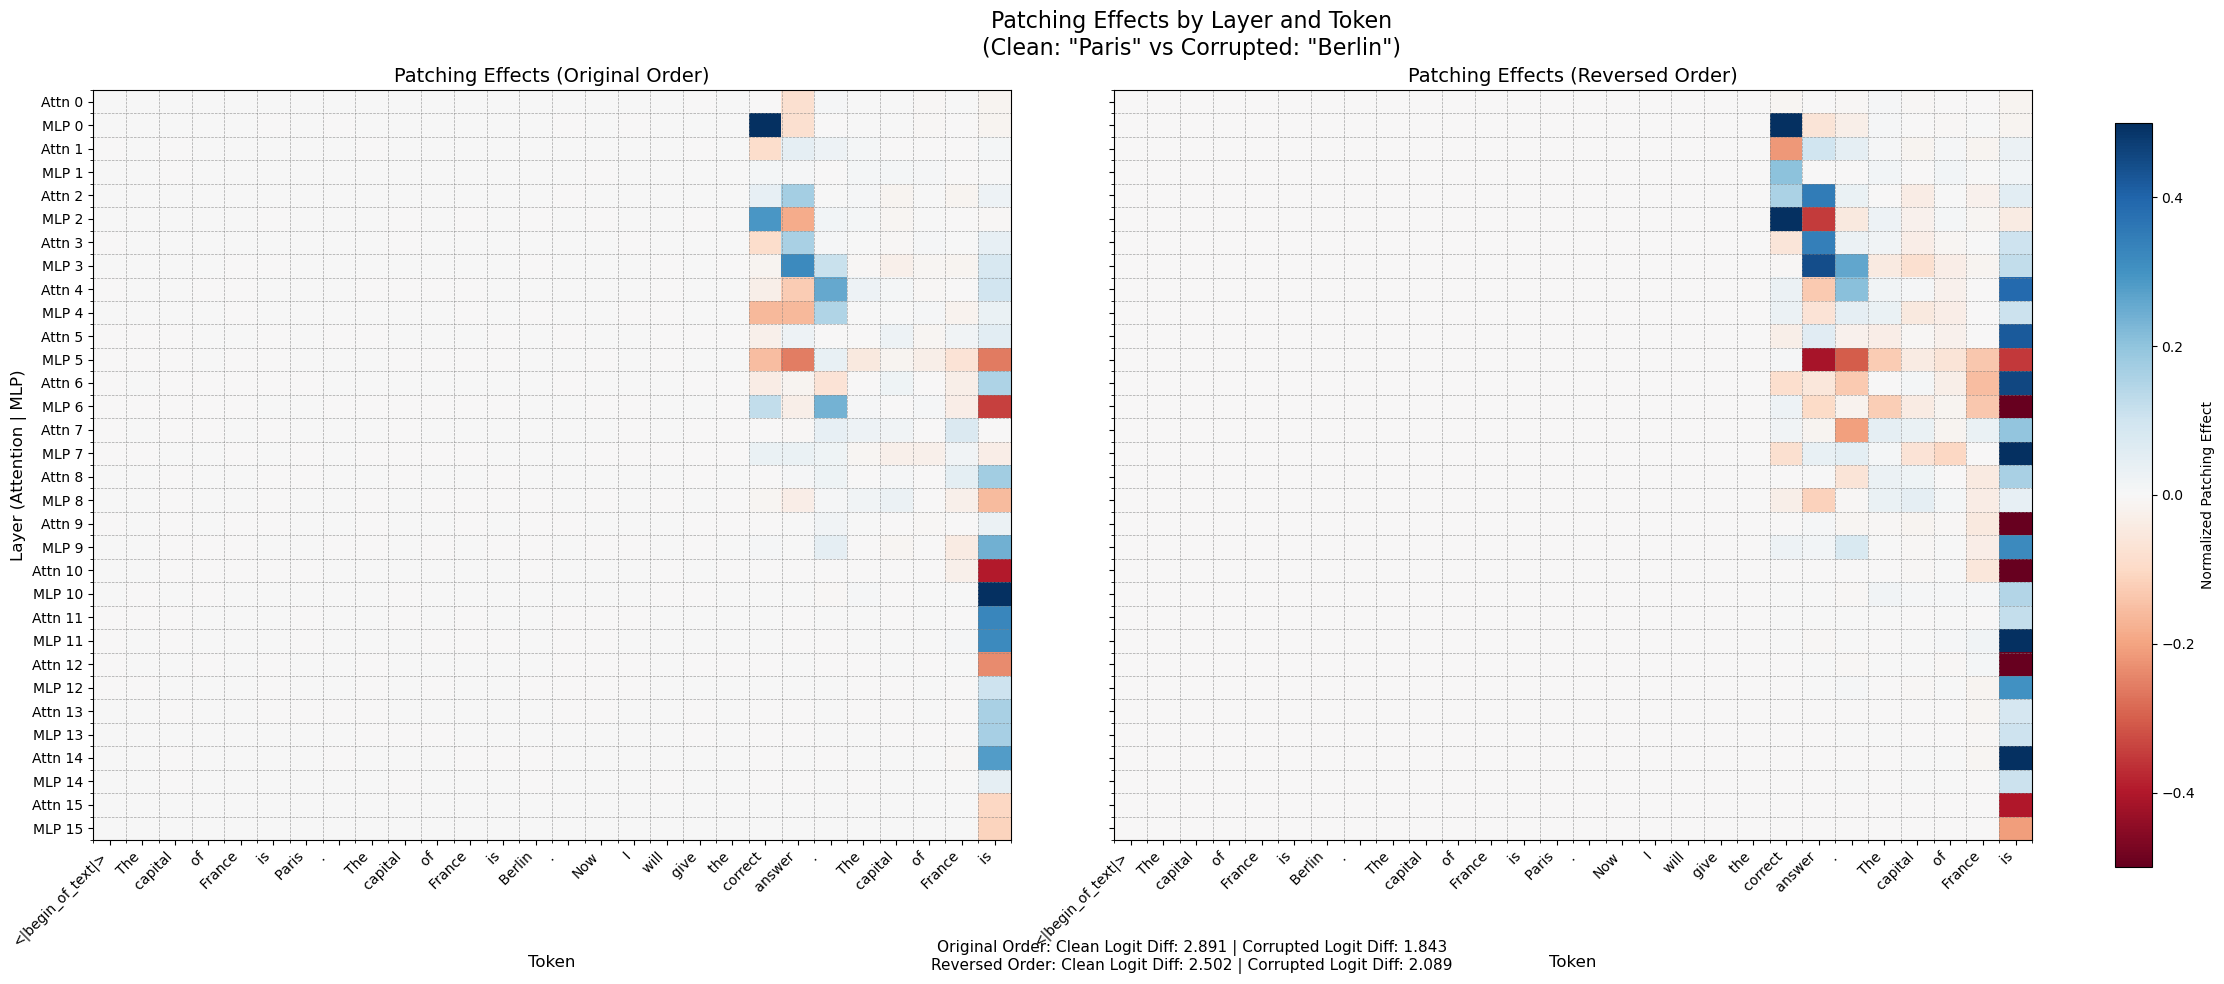

/var/folders/d3/vz_c28ls63xgtw6pgtpkccrw0000gn/T/ipykernel_23922/1602779583.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


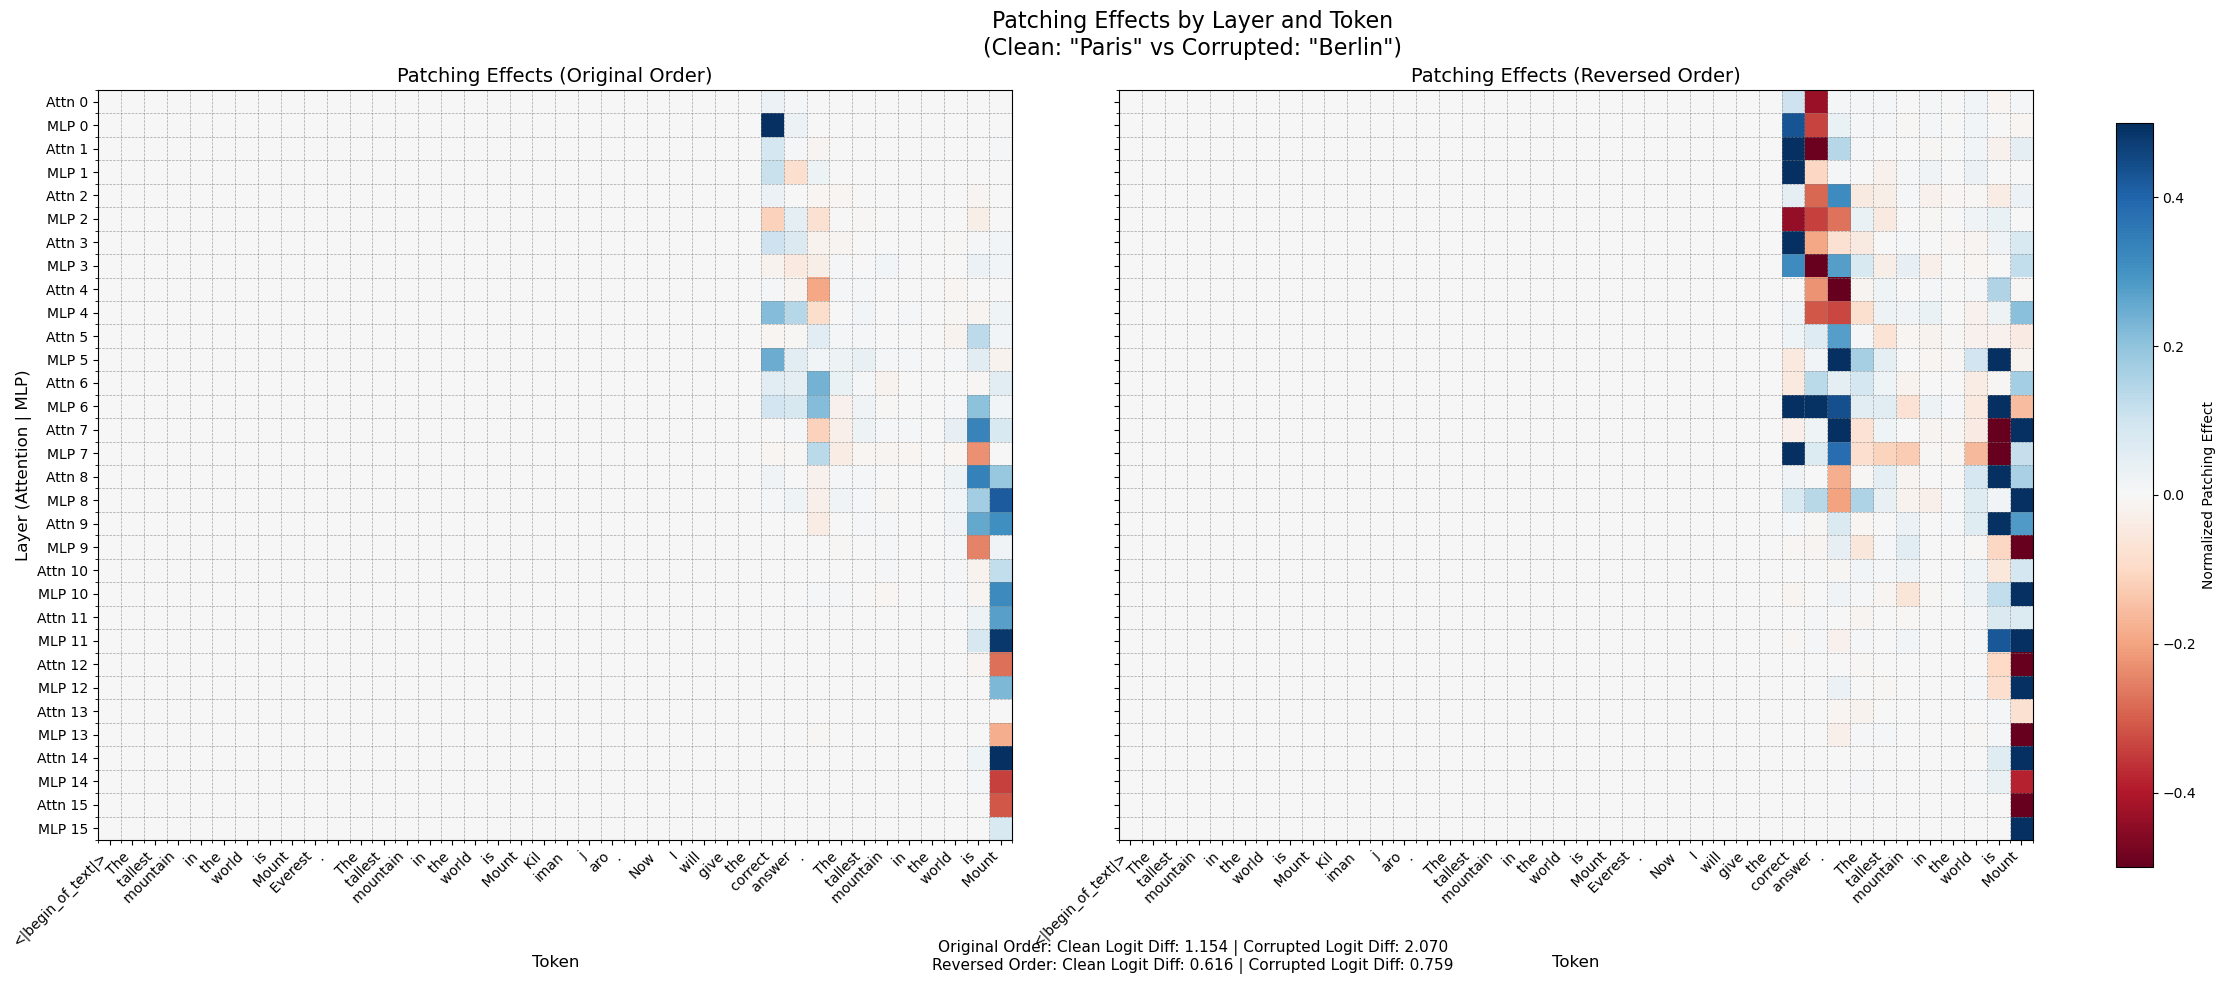

/var/folders/d3/vz_c28ls63xgtw6pgtpkccrw0000gn/T/ipykernel_23922/1602779583.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


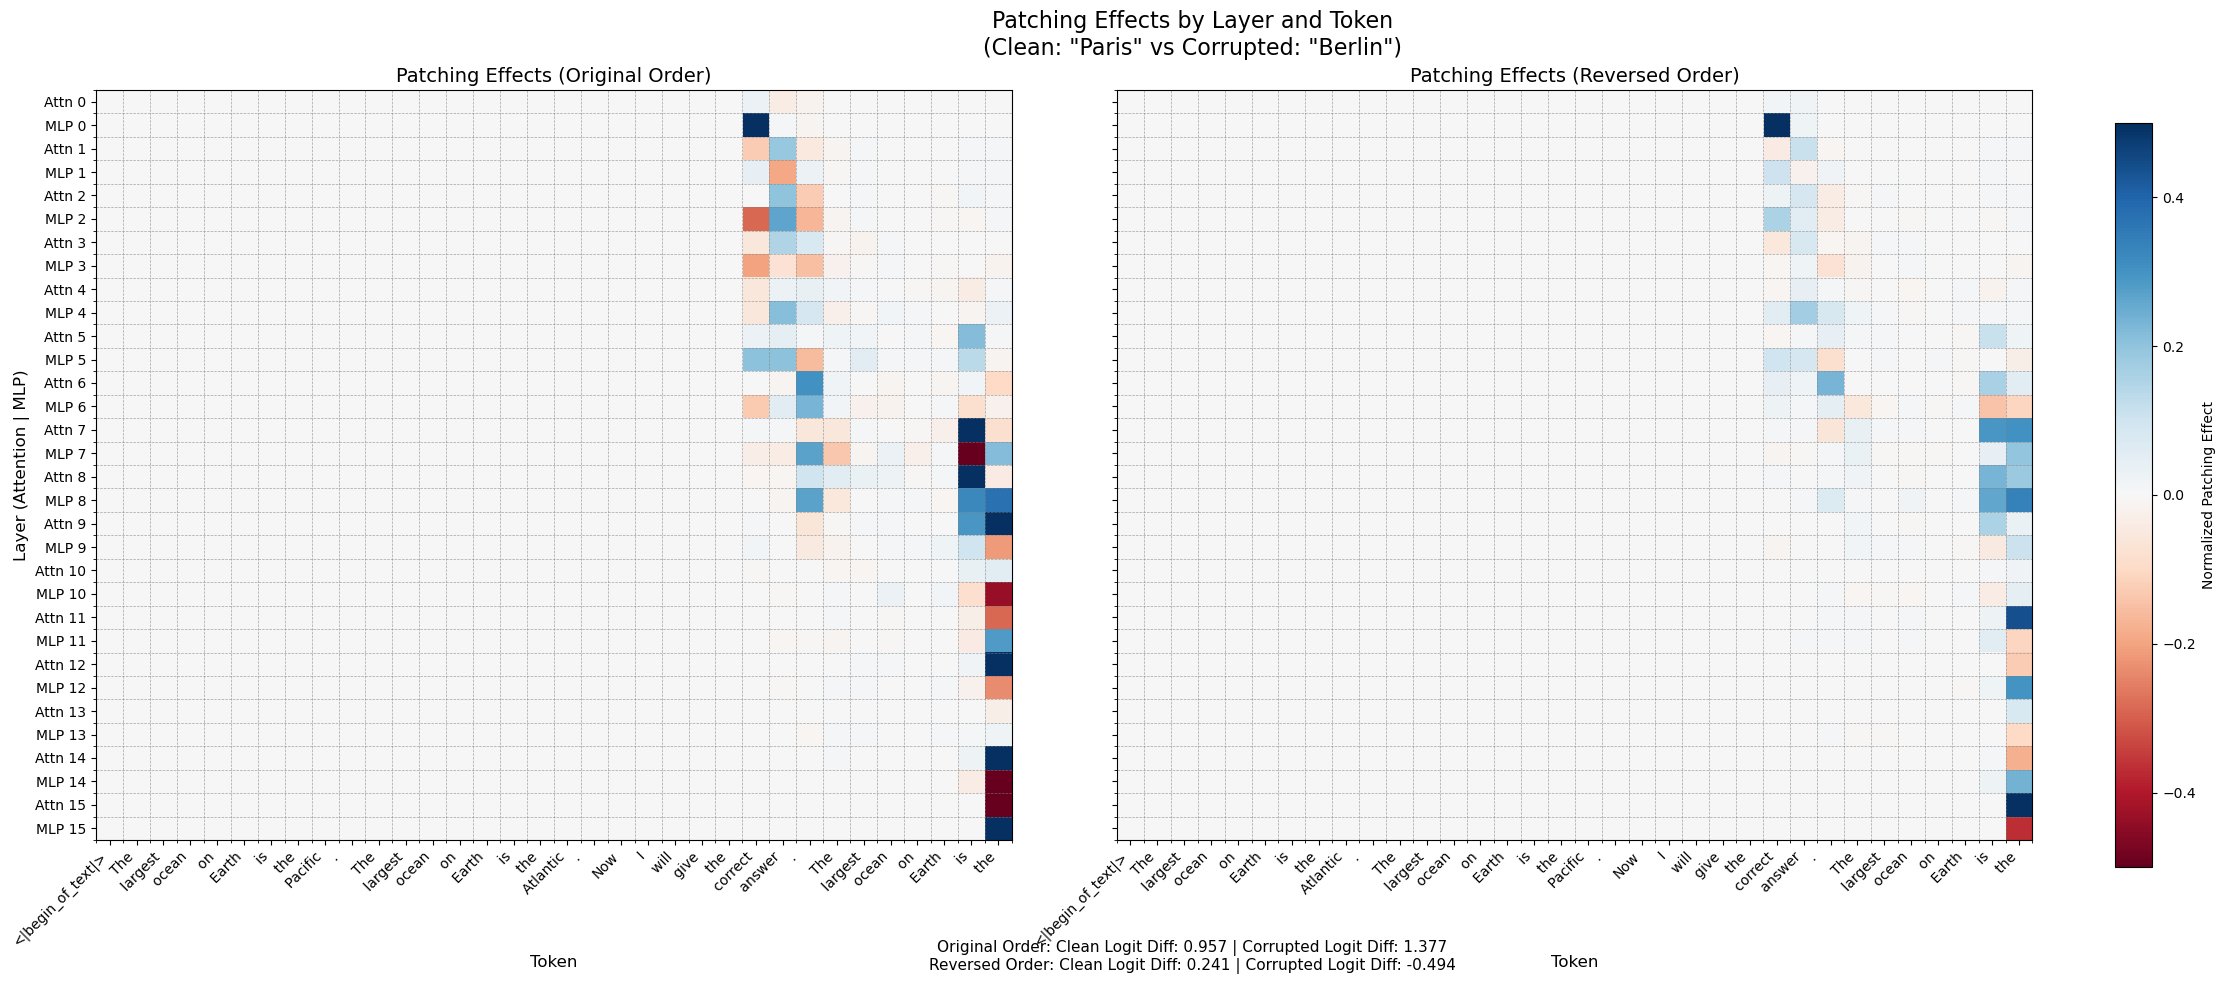

/var/folders/d3/vz_c28ls63xgtw6pgtpkccrw0000gn/T/ipykernel_23922/1602779583.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


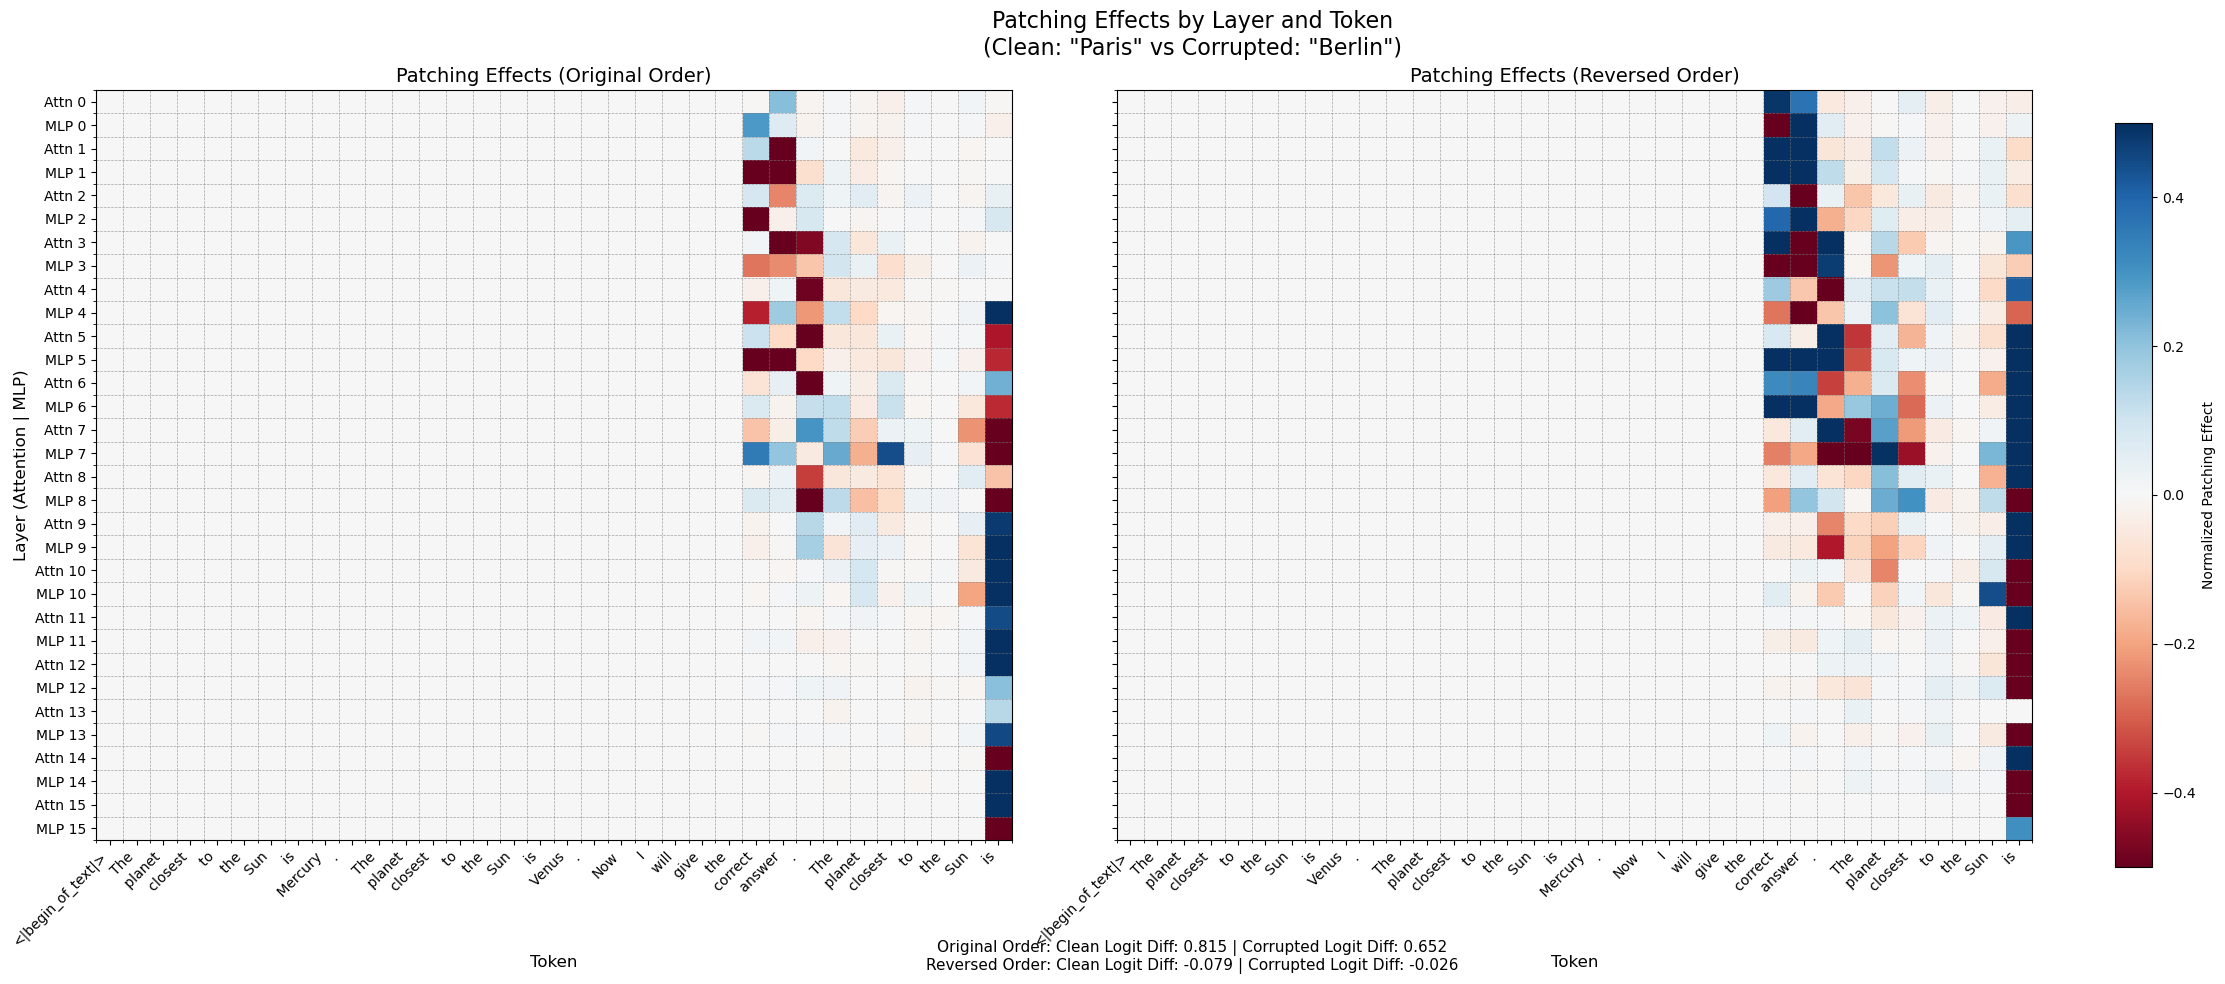

/var/folders/d3/vz_c28ls63xgtw6pgtpkccrw0000gn/T/ipykernel_23922/1602779583.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


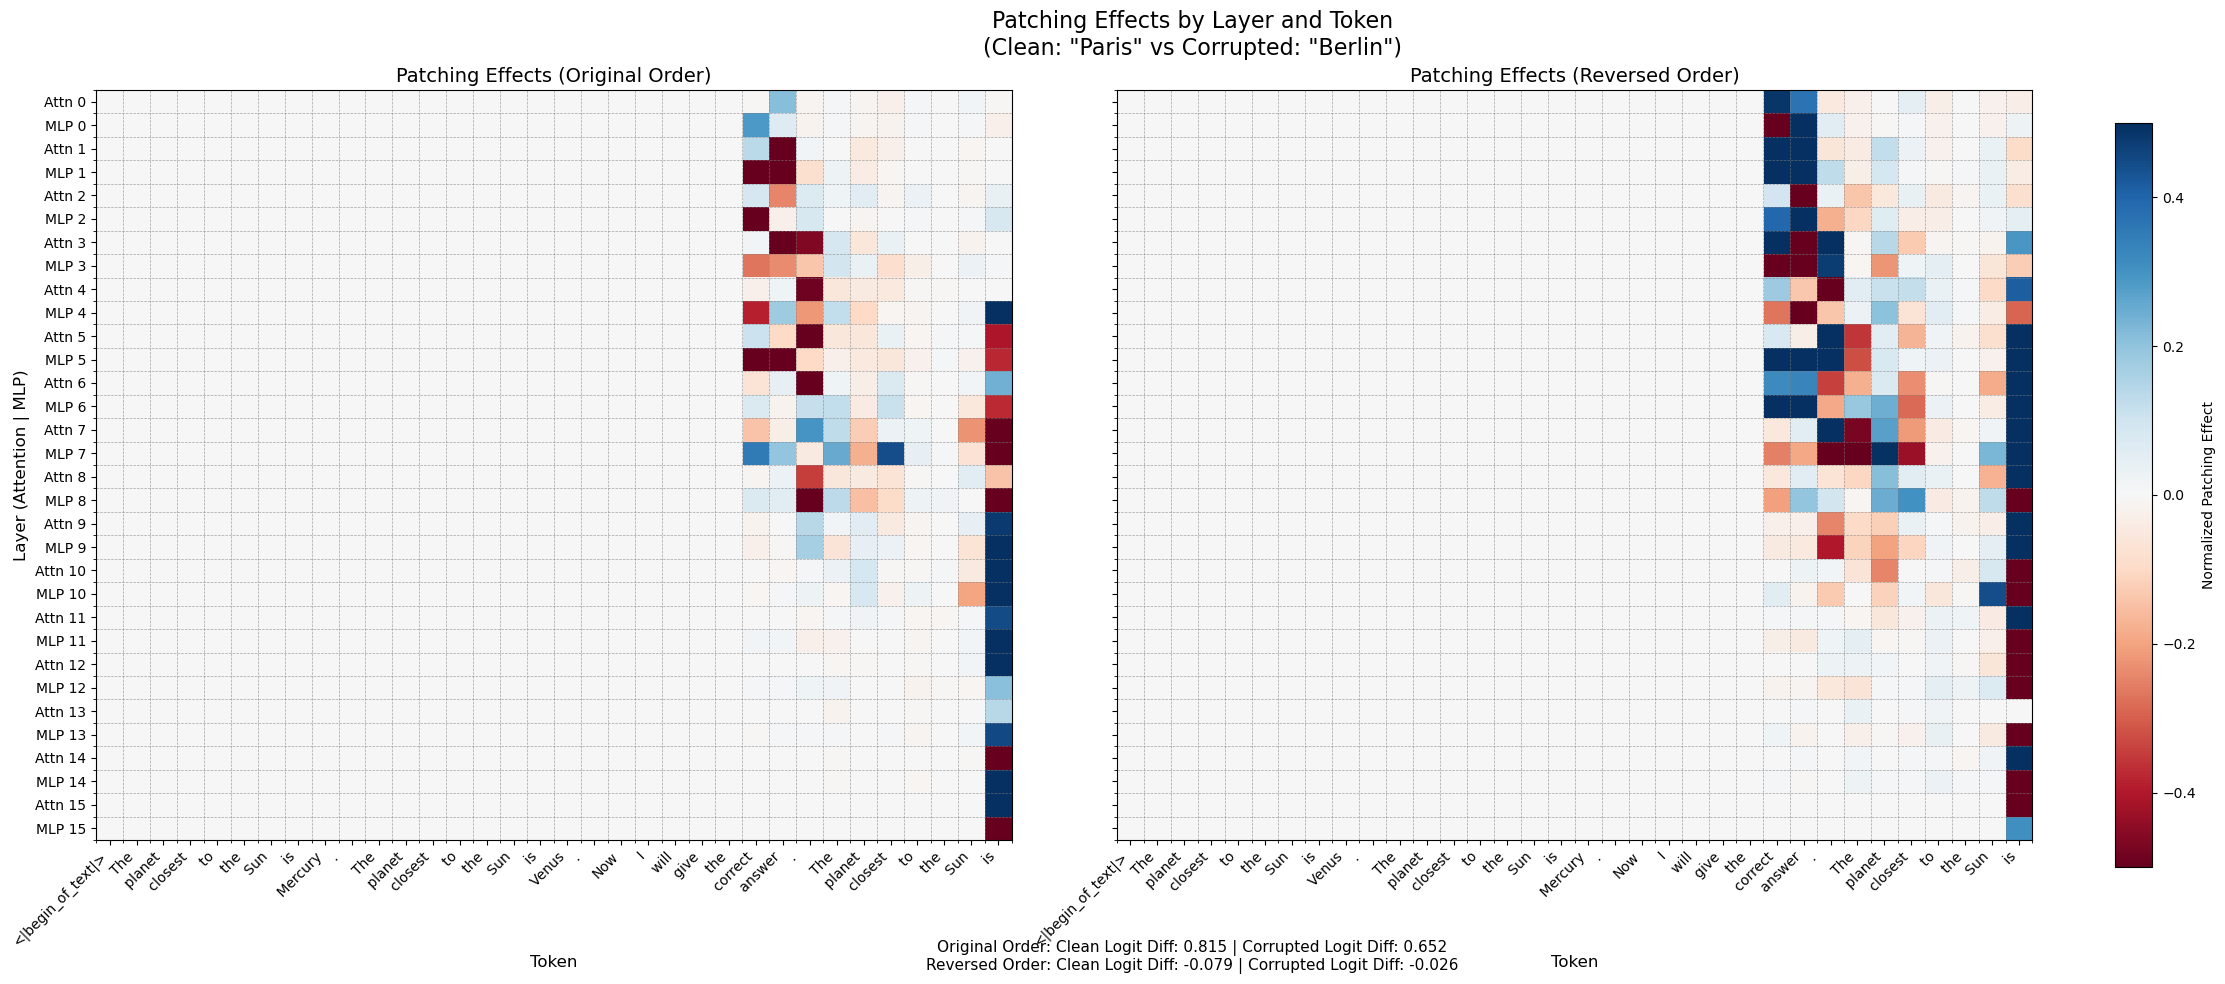

/var/folders/d3/vz_c28ls63xgtw6pgtpkccrw0000gn/T/ipykernel_23922/1602779583.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


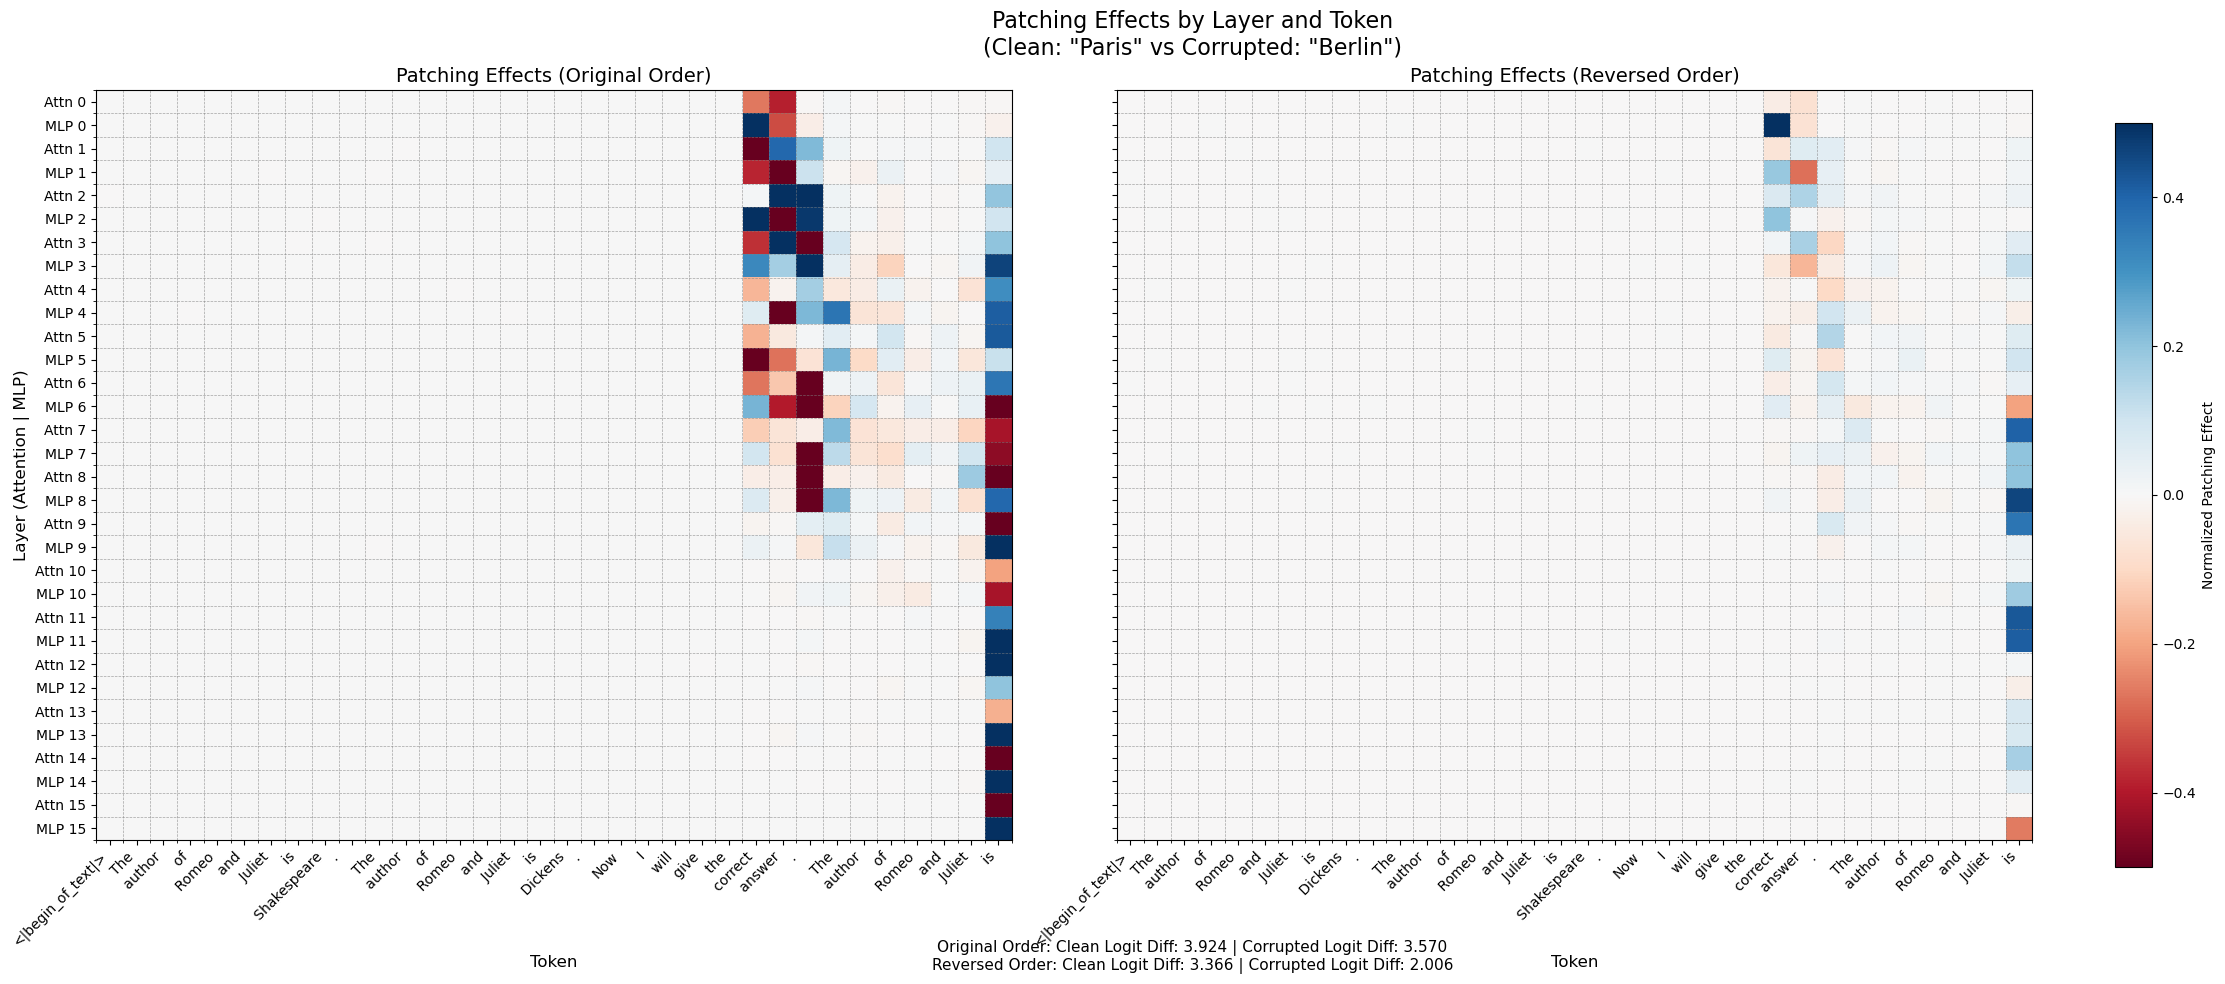

/var/folders/d3/vz_c28ls63xgtw6pgtpkccrw0000gn/T/ipykernel_23922/1602779583.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


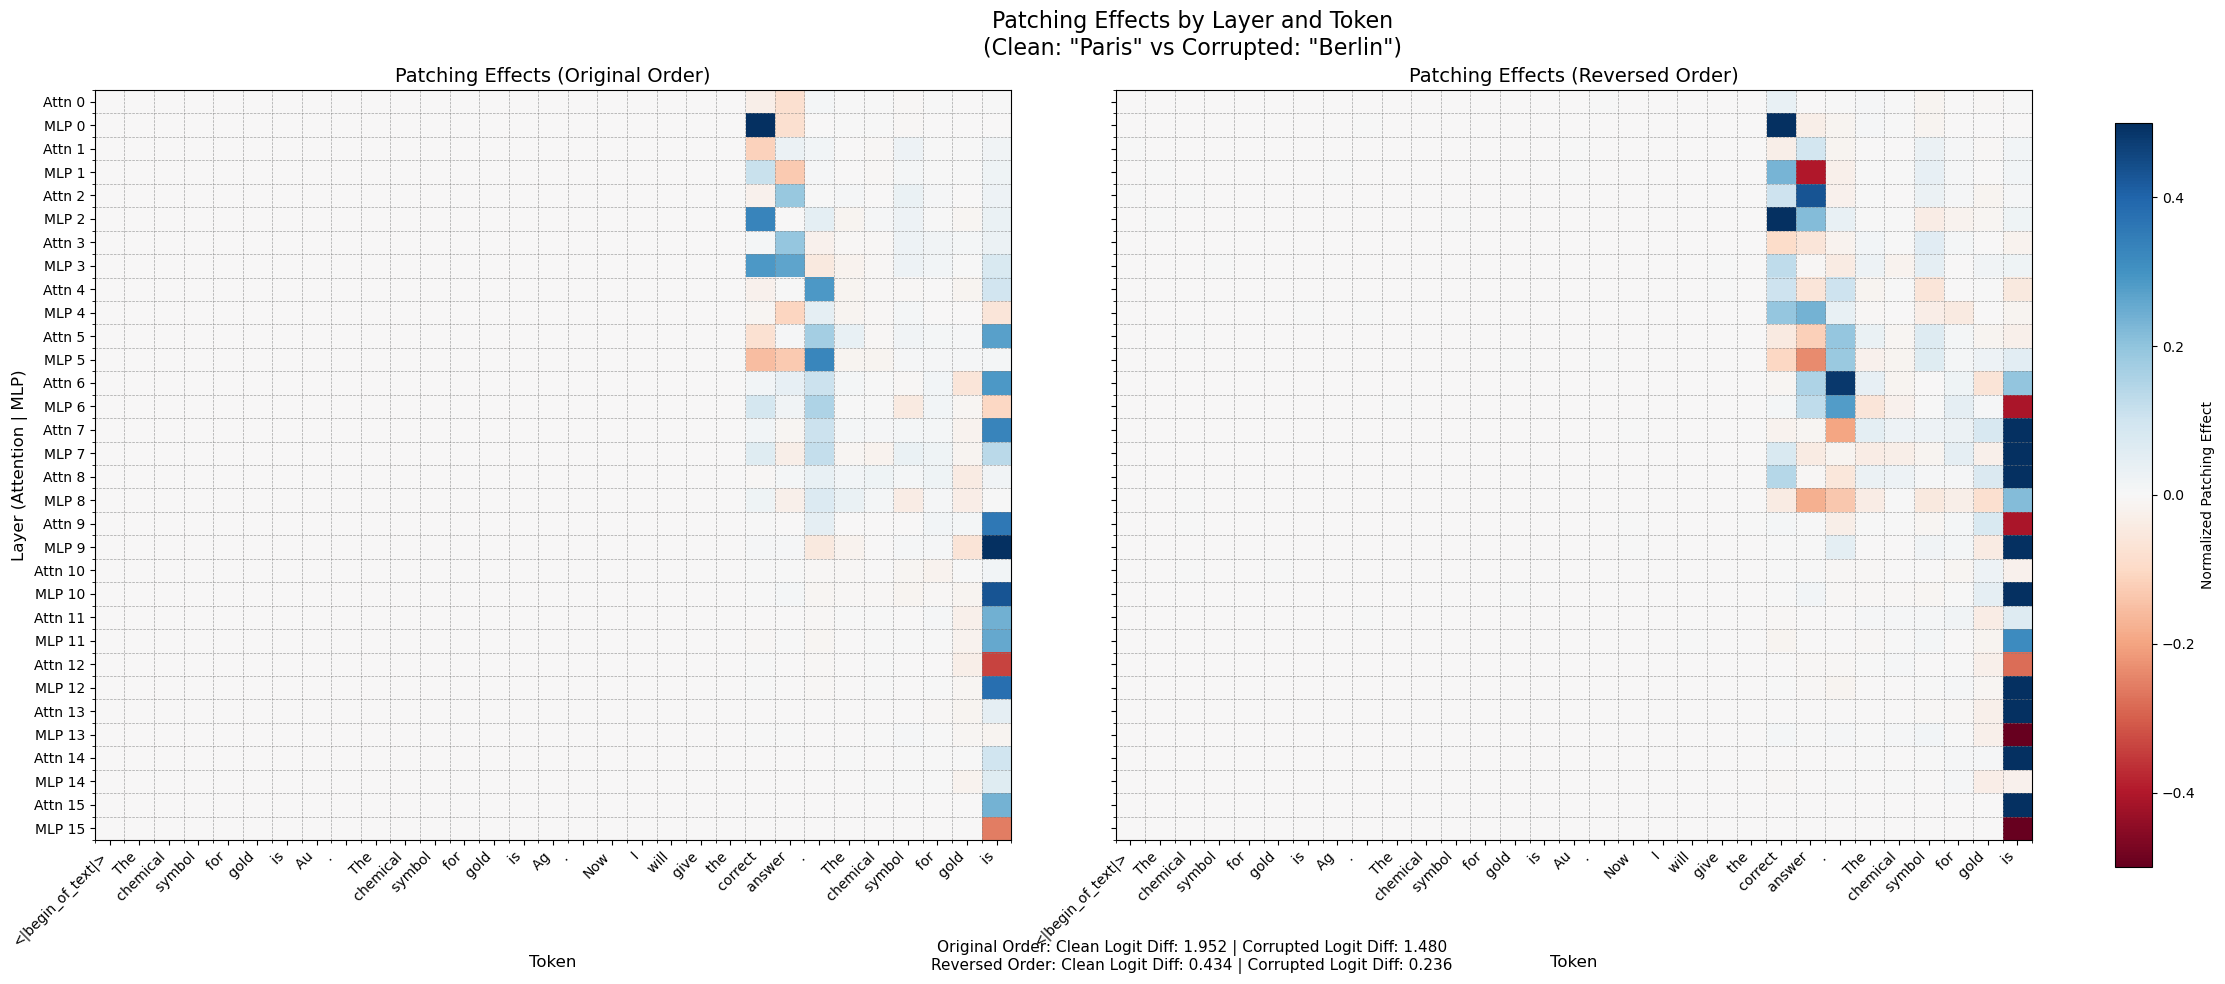

/var/folders/d3/vz_c28ls63xgtw6pgtpkccrw0000gn/T/ipykernel_23922/1602779583.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


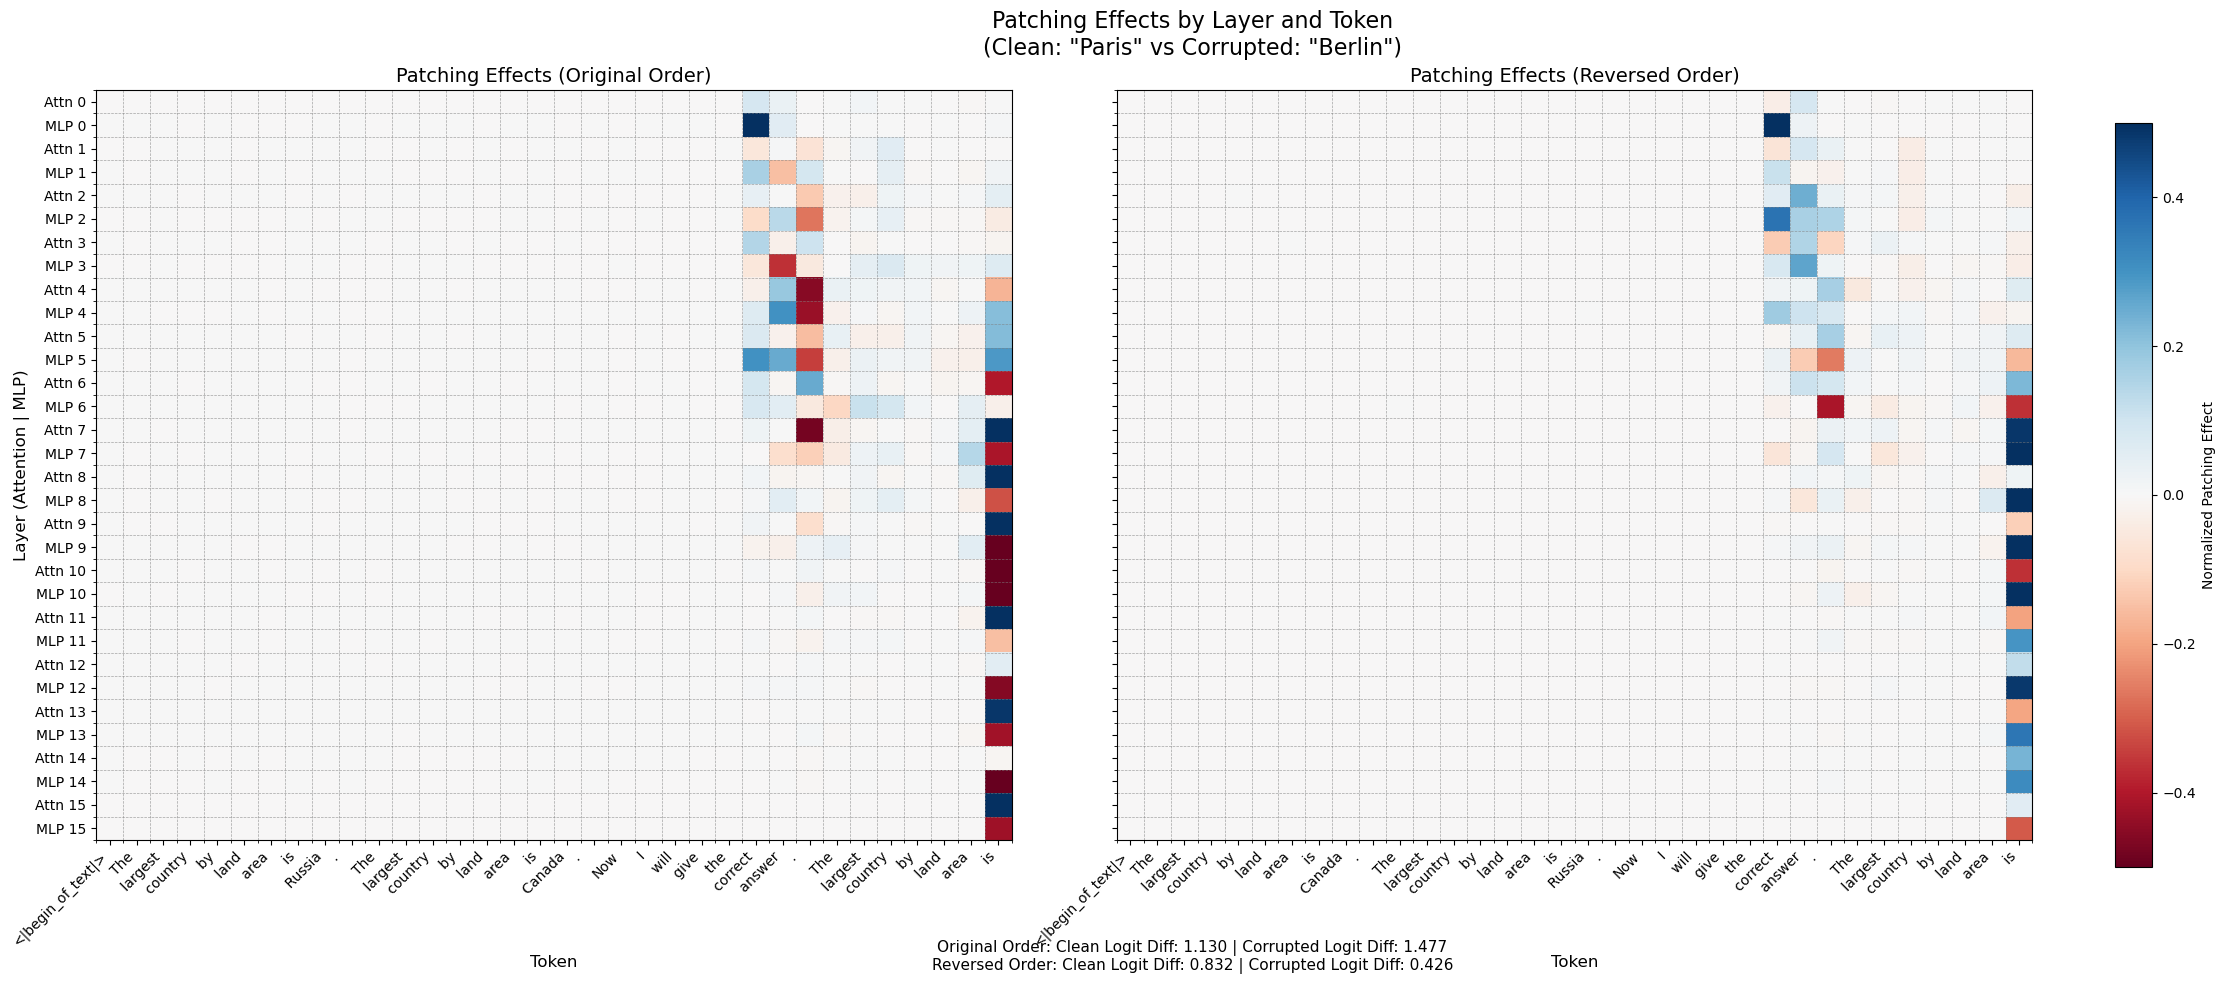

/var/folders/d3/vz_c28ls63xgtw6pgtpkccrw0000gn/T/ipykernel_23922/1602779583.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


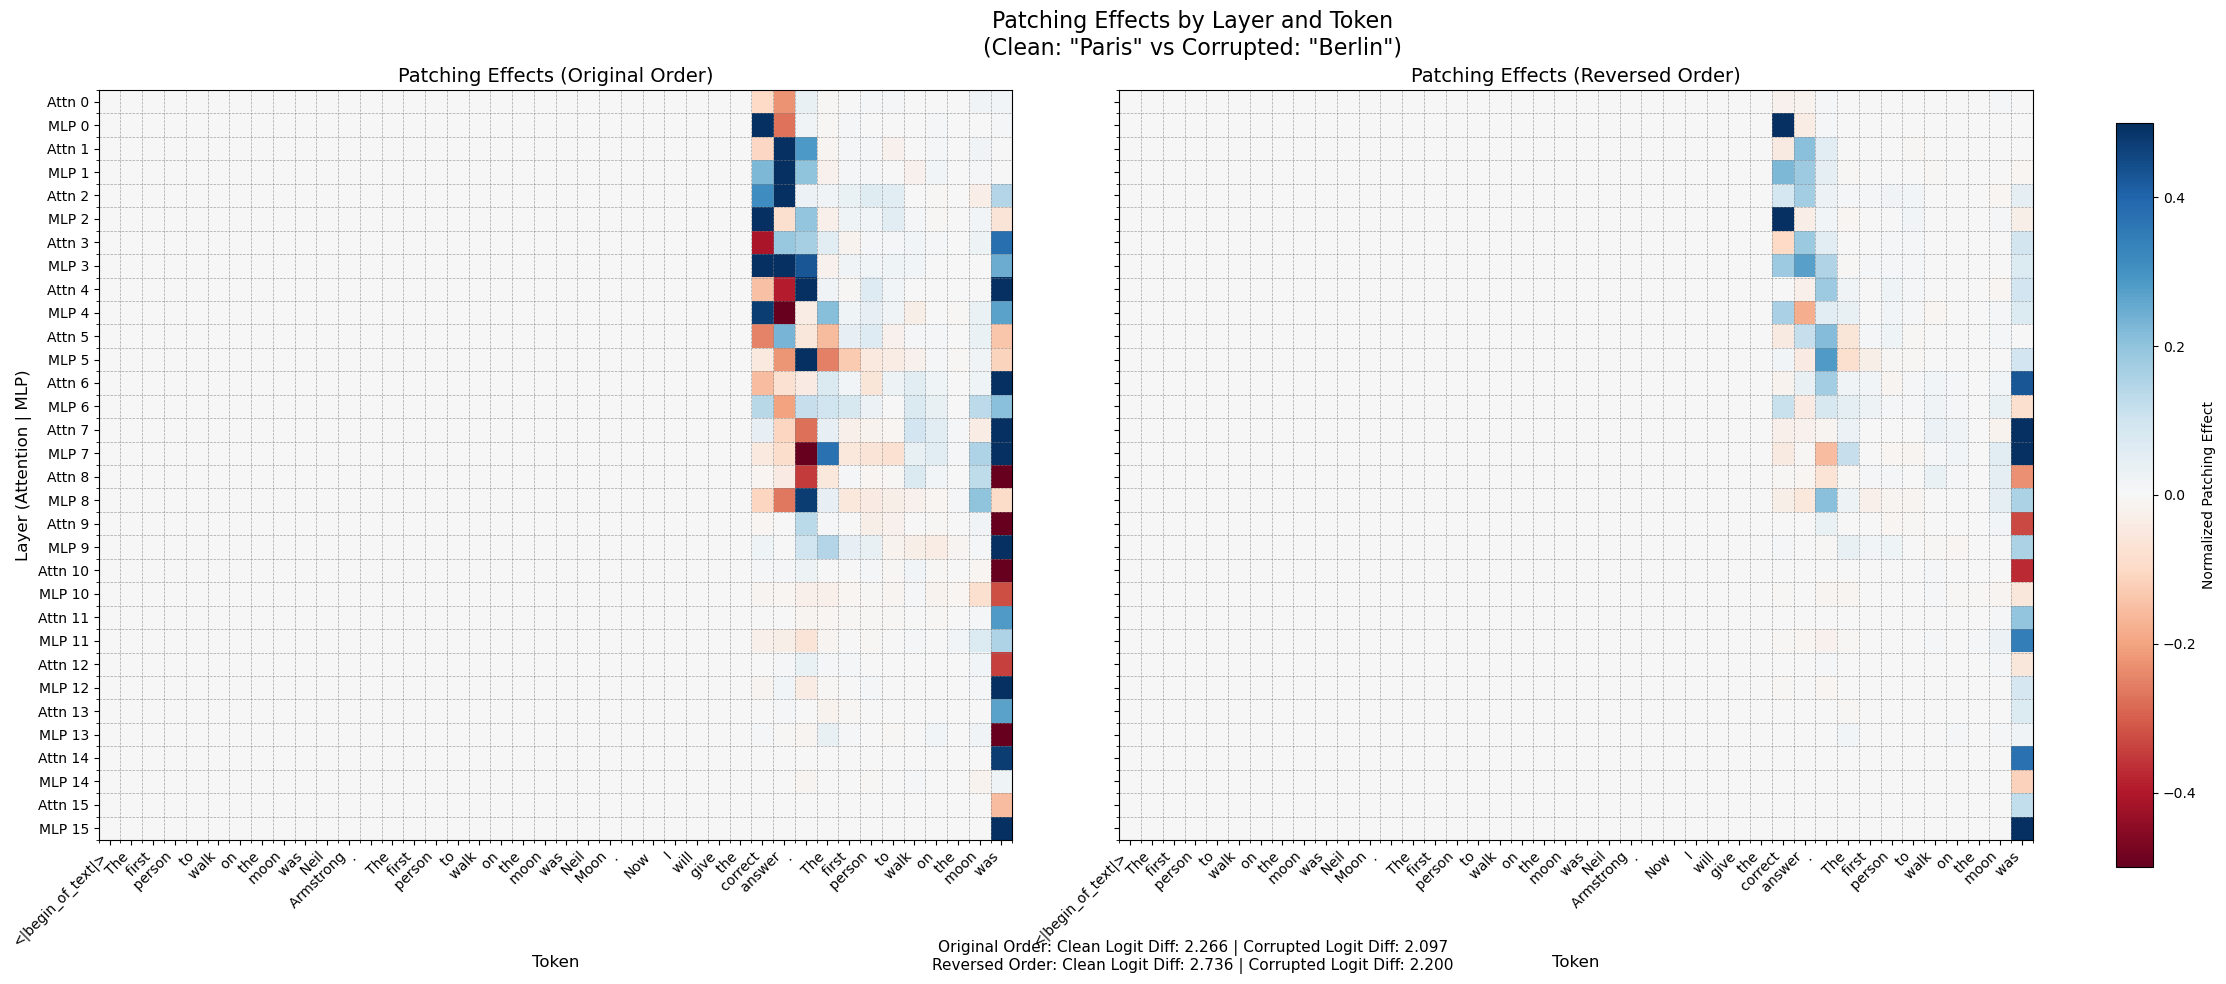

/var/folders/d3/vz_c28ls63xgtw6pgtpkccrw0000gn/T/ipykernel_23922/1602779583.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


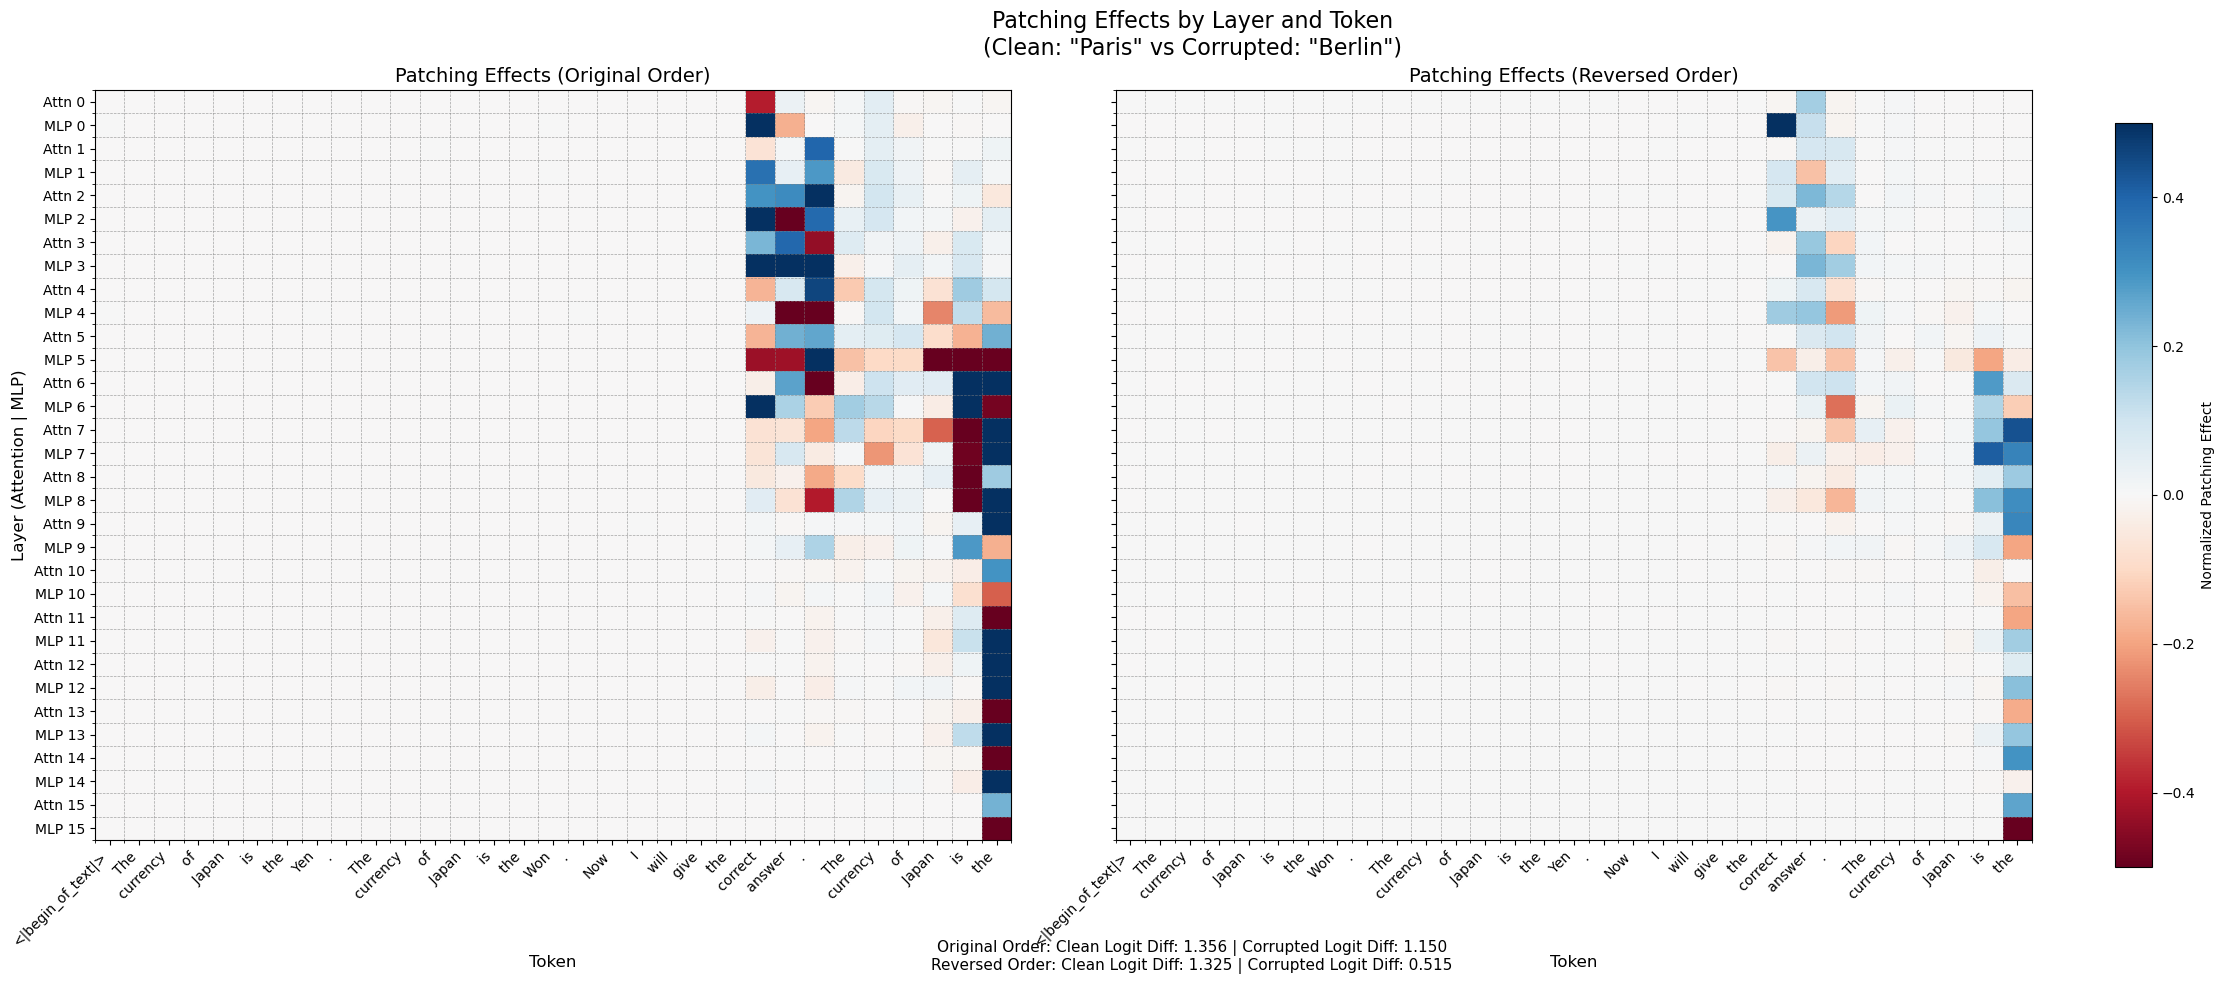

/var/folders/d3/vz_c28ls63xgtw6pgtpkccrw0000gn/T/ipykernel_23922/1602779583.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


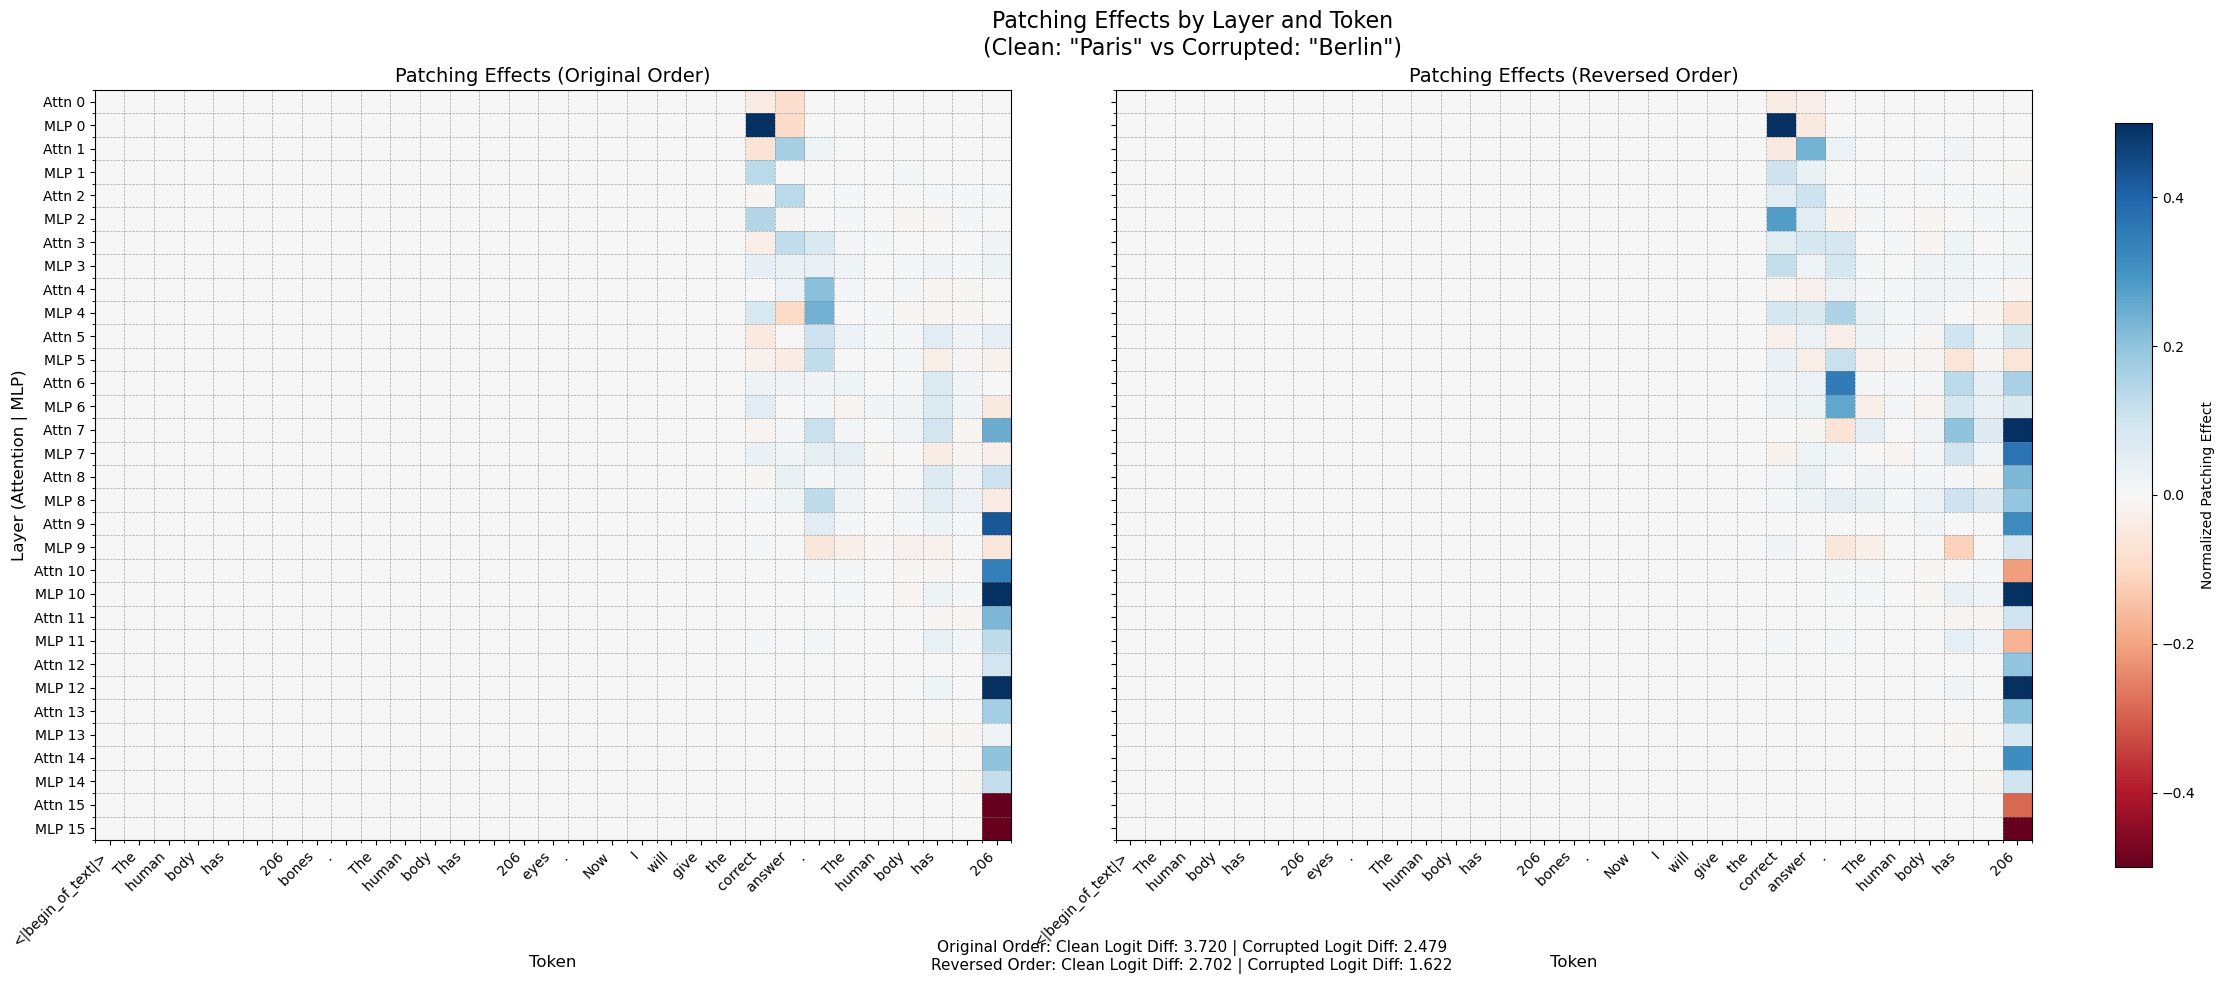

In [35]:
# Locate the current directory
current_dir = os.getcwd()
print(f"current_dir={current_dir}")
# Read from the csv file the sentences s1, s2, and last_sentence
df = pd.read_csv(os.path.join(current_dir, "sentences.csv"))

# Iterate over the rows of the dataframe and plot the patching effects for each row
for i in range(len(df)):
    s1 = df.iloc[i]["sentence1"]
    s2 = df.iloc[i]["sentence2"]
    last_sentence = df.iloc[i]["last_sentence"]

    prompt = f"{s1}\n{s2}\nNow I will give the correct answer.\n{last_sentence}"
    corrupted_prompt = f"{s1}\n{s2}\nNow I will give the incorrect answer.\n{last_sentence}"

    prompt_reversed = f"{s2}\n{s1}\nNow I will give the correct answer.\n{last_sentence}"   
    corrupted_prompt_reversed = f"{s2}\n{s1}\nNow I will give the incorrect answer.\n{last_sentence}"

    prompts = [prompt, corrupted_prompt]
    prompts_reversed = [prompt_reversed, corrupted_prompt_reversed]

    # Define the answers to these prompts, formatted as (correct, incorrect)
    answers = [
        (df.iloc[i]["answer_sentence1"], df.iloc[i]["answer_sentence2"]),
    ]

    answer_token_indices = [
        [llm.tokenizer(answers[i][j])["input_ids"][1] for j in range(2)]
        for i in range(len(answers))
    ]

    patching_results, clean_tokens = run_activation_patching(prompts, answer_token_indices)
    patching_results_reversed, clean_tokens_reversed = run_activation_patching(prompts_reversed, answer_token_indices)
    plot_patching_effects_single_heatmap_mlp_attn_combined(patching_results, patching_results_reversed, clean_tokens, clean_tokens_reversed, i)